In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
!pip install pmdarima

In [9]:
from pmdarima import auto_arima

In [10]:
bikes = pd.read_csv('bike_sales.csv')
bikes.head()

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,26/11/2013,26,November,2013,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
1,26/11/2015,26,November,2015,19,Youth (<25),M,Canada,British Columbia,Accessories,Bike Racks,Hitch Rack - 4-Bike,8,45,120,590,360,950
2,23/03/2014,23,March,2014,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,23,45,120,1366,1035,2401
3,23/03/2016,23,March,2016,49,Adults (35-64),M,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,20,45,120,1188,900,2088
4,15/05/2014,15,May,2014,47,Adults (35-64),F,Australia,New South Wales,Accessories,Bike Racks,Hitch Rack - 4-Bike,4,45,120,238,180,418


In [12]:
bikes['Date']=pd.to_datetime(bikes['Date'], format='%d/%m/%Y')
bikes.set_index(['Date'], inplace=True)

In [16]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [17]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

# Weekly Sales - All Data

In [20]:
weekly_sales = bikes[['Revenue']].resample('W').sum()

In [22]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 12})

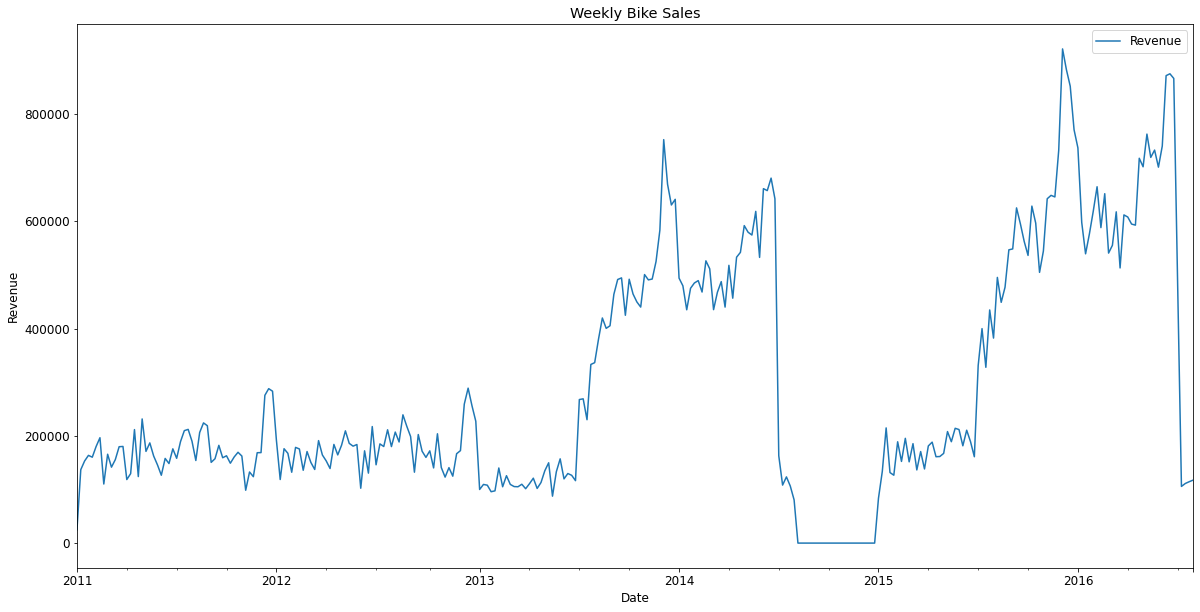

In [23]:
weekly_sales.plot()
plt.title('Weekly Bike Sales')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

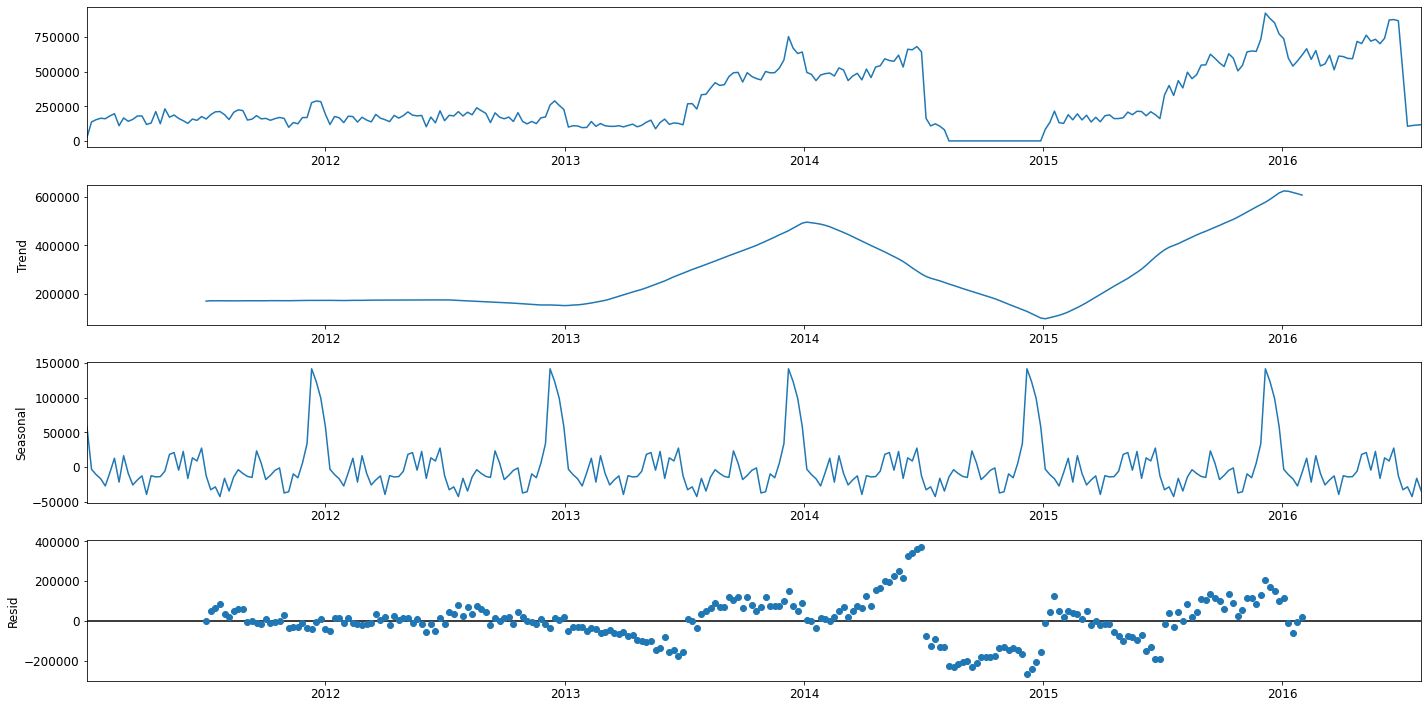

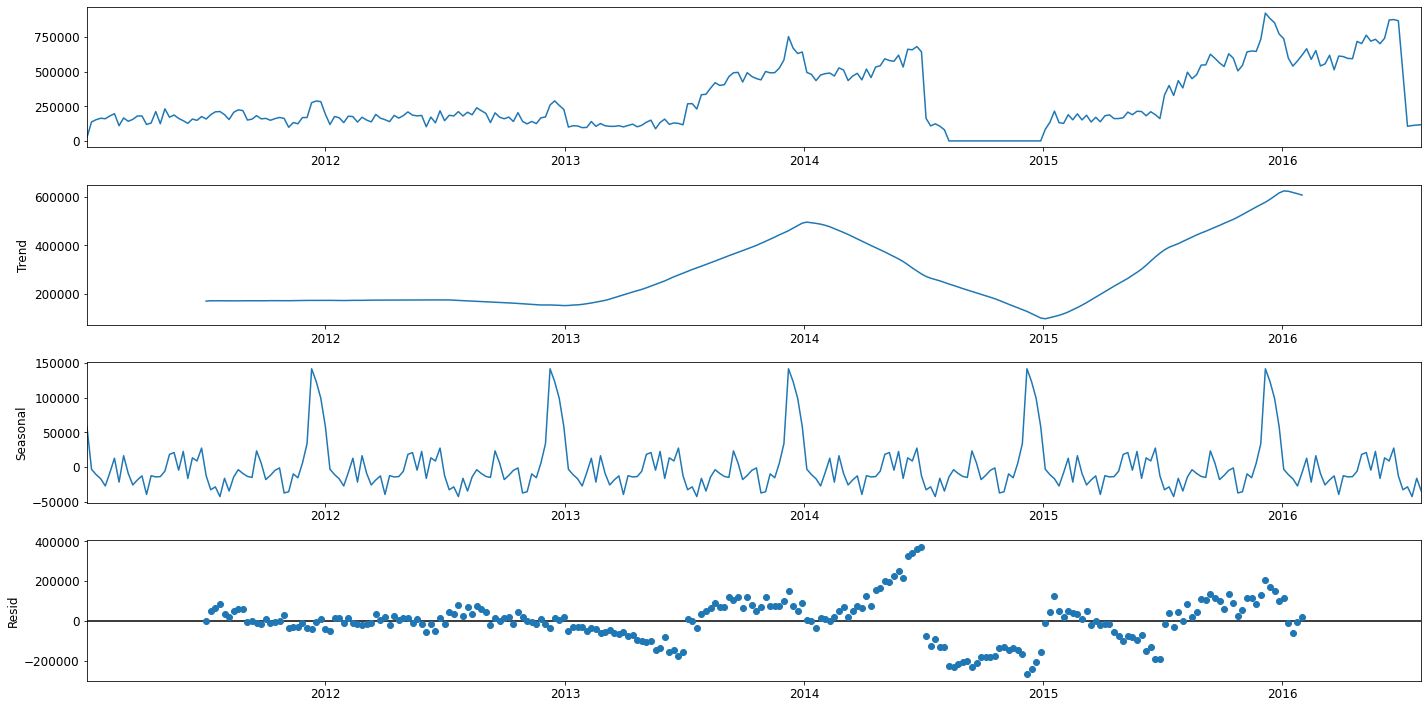

In [27]:
decomposition = seasonal_decompose(weekly_sales, period=52)
decomposition.plot()

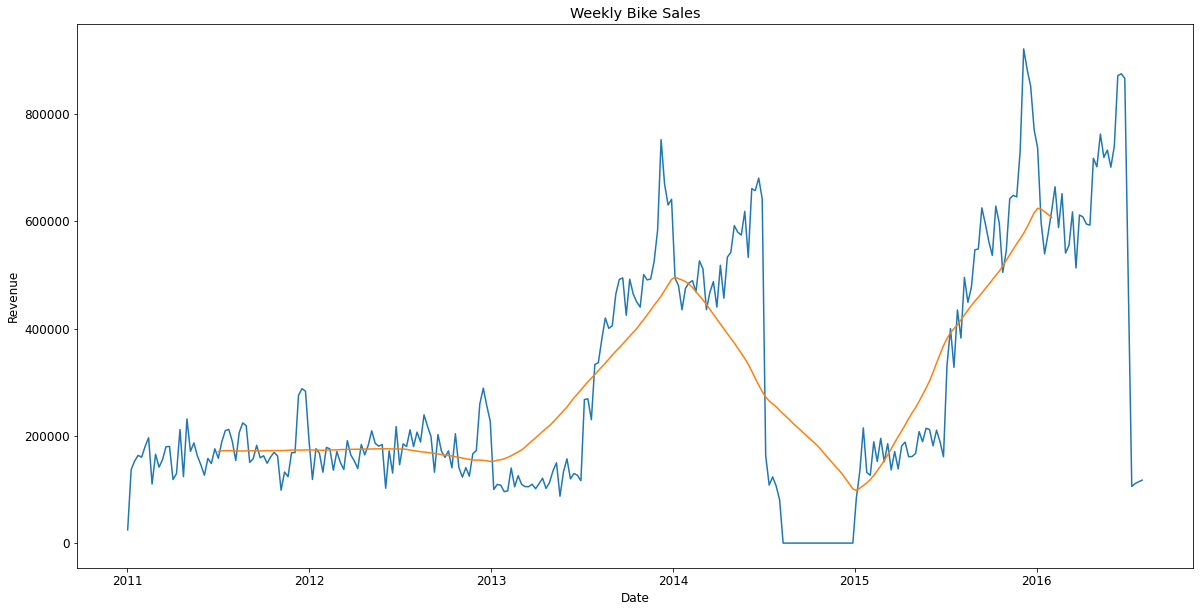

In [29]:
plt.title('Weekly Bike Sales')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.plot(weekly_sales)
plt.plot(decomposition.trend)

# Before 2014

In [35]:
before_2014 = pd.DataFrame(weekly_sales['2011':'2014']).dropna()

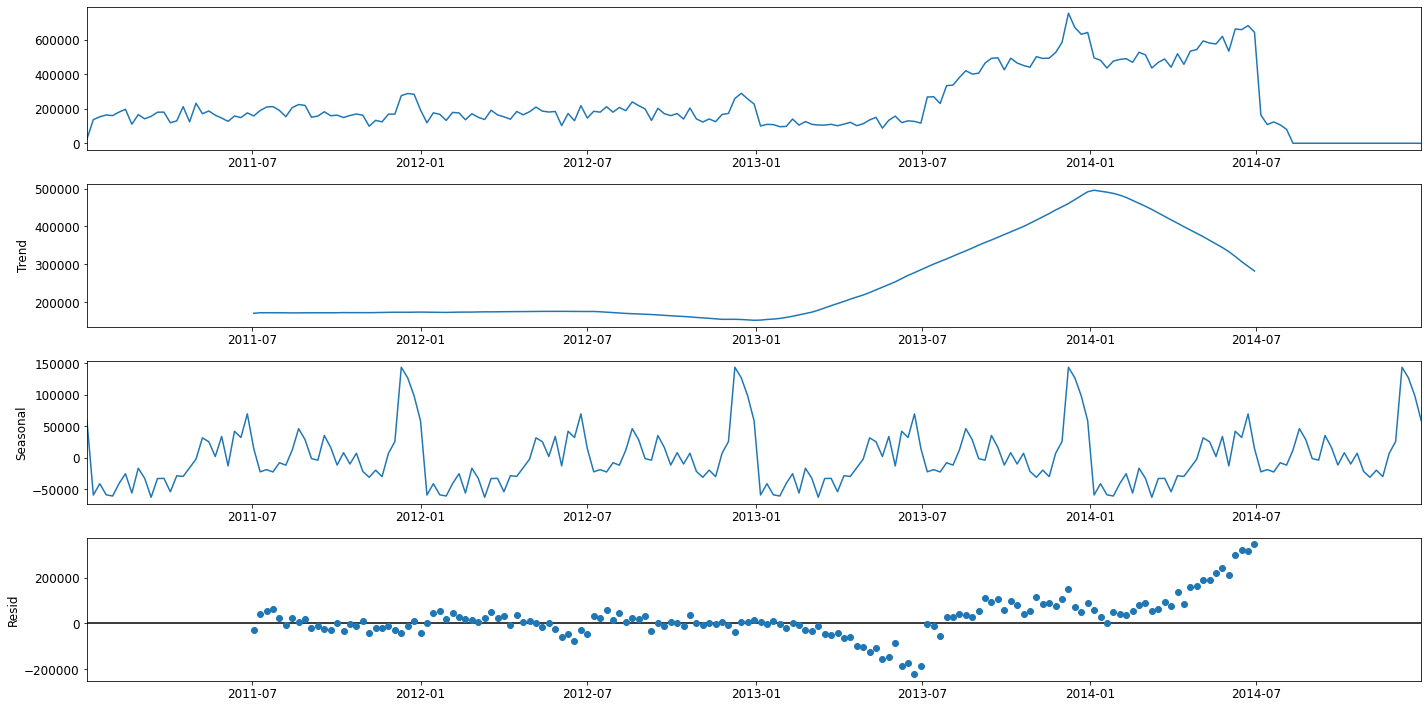

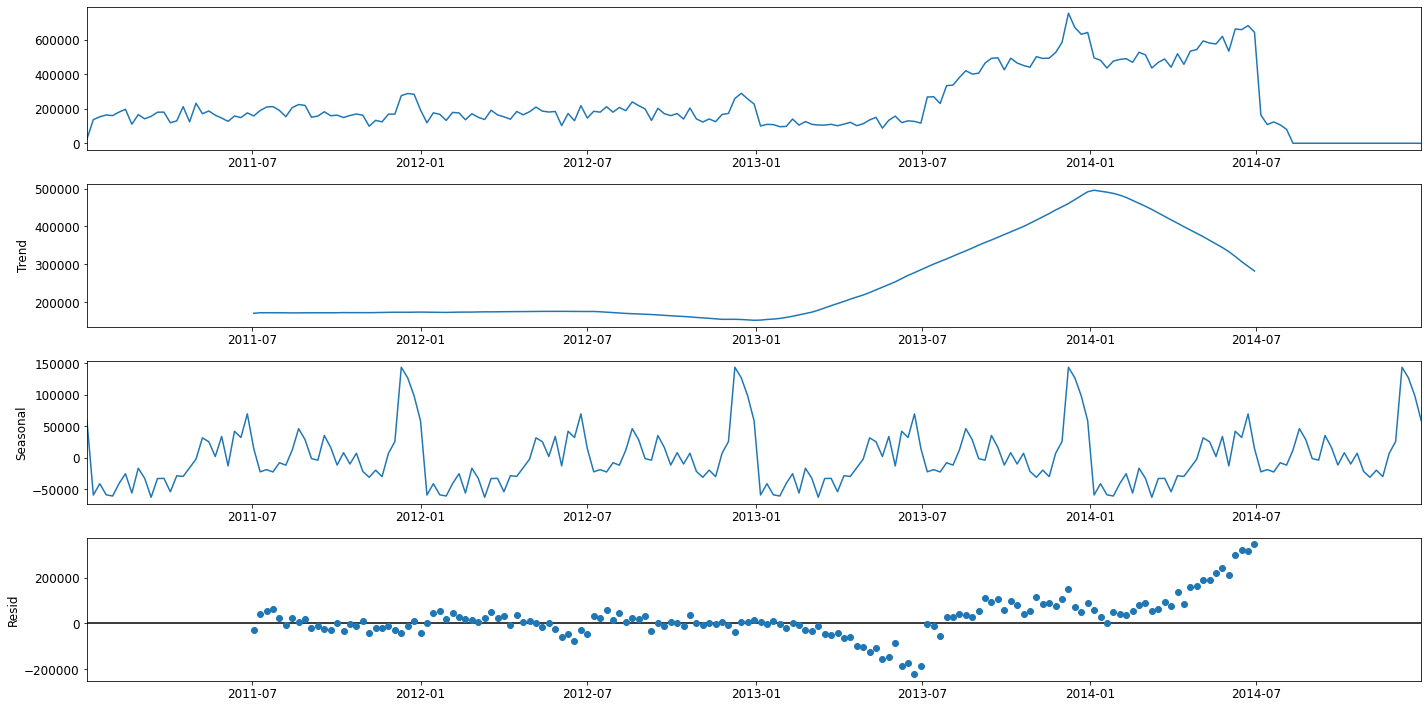

In [36]:
decomposition = seasonal_decompose(before_2014, period=52)
decomposition.plot()

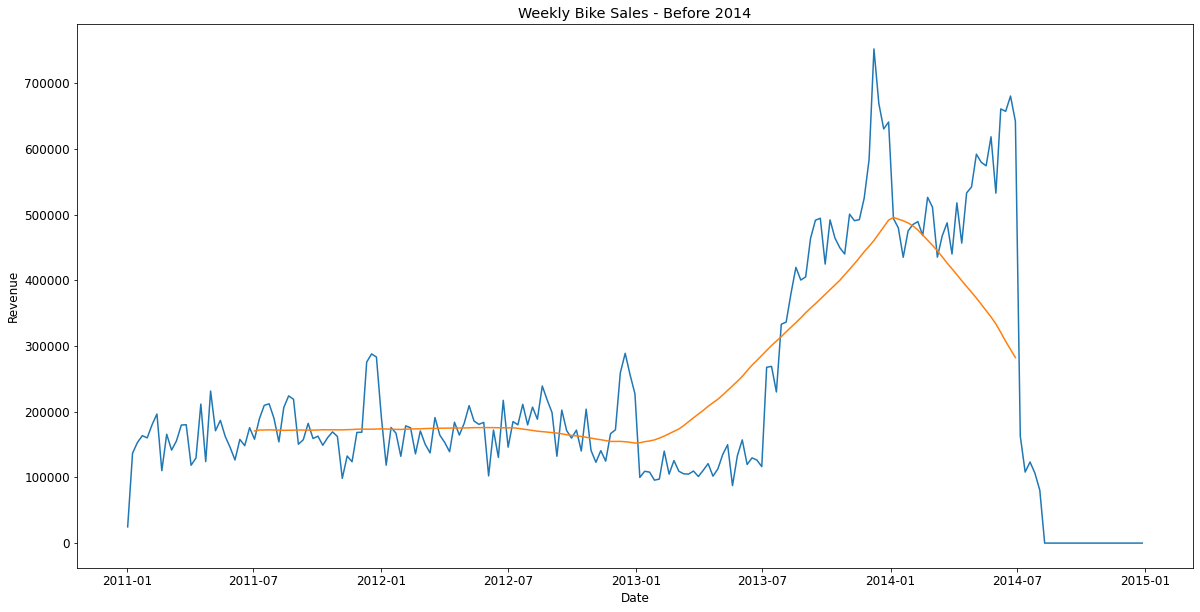

In [38]:
plt.title('Weekly Bike Sales - Before 2014')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.plot(before_2014)
plt.plot(decomposition.trend)

# Auto-Correlation

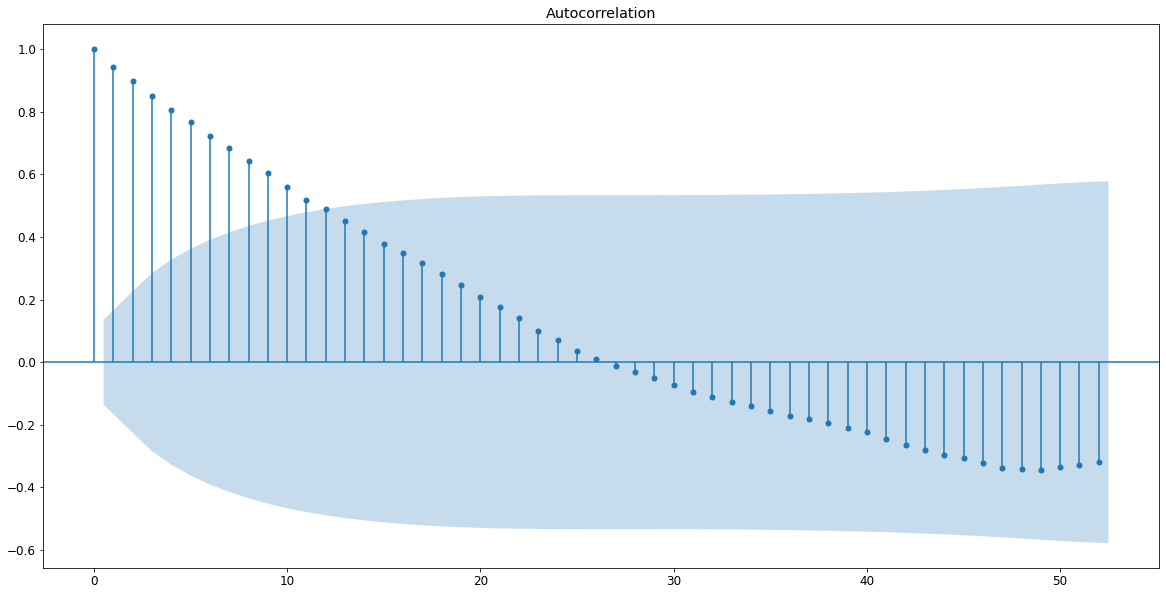

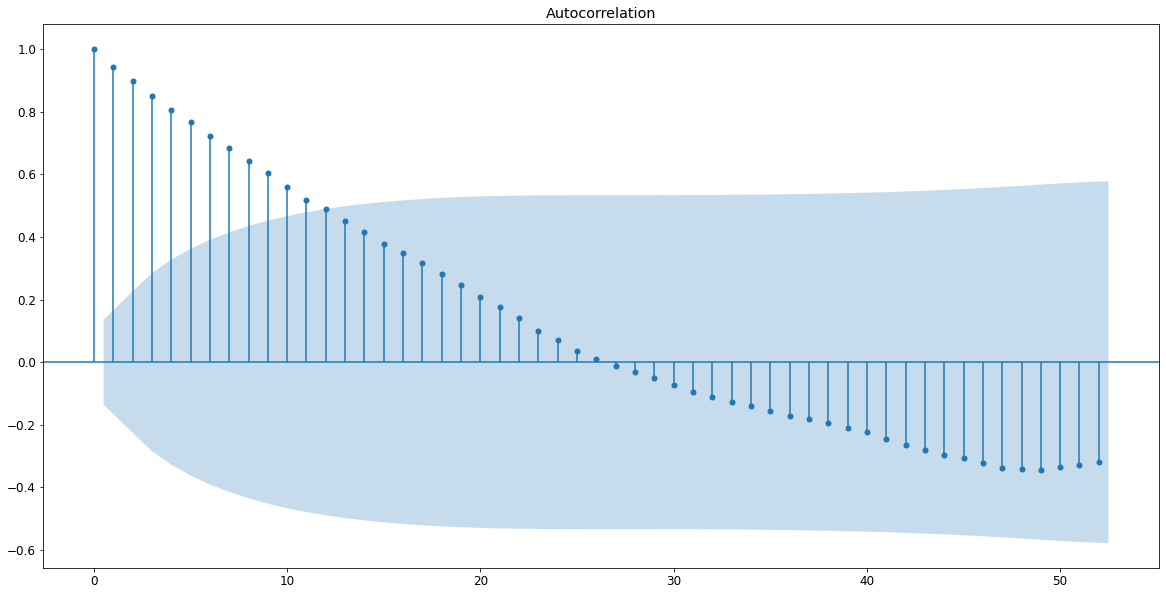

In [45]:
plot_acf(before_2014, lags = 52)

In [46]:
before_2014_diff = before_2014.diff(1).dropna()

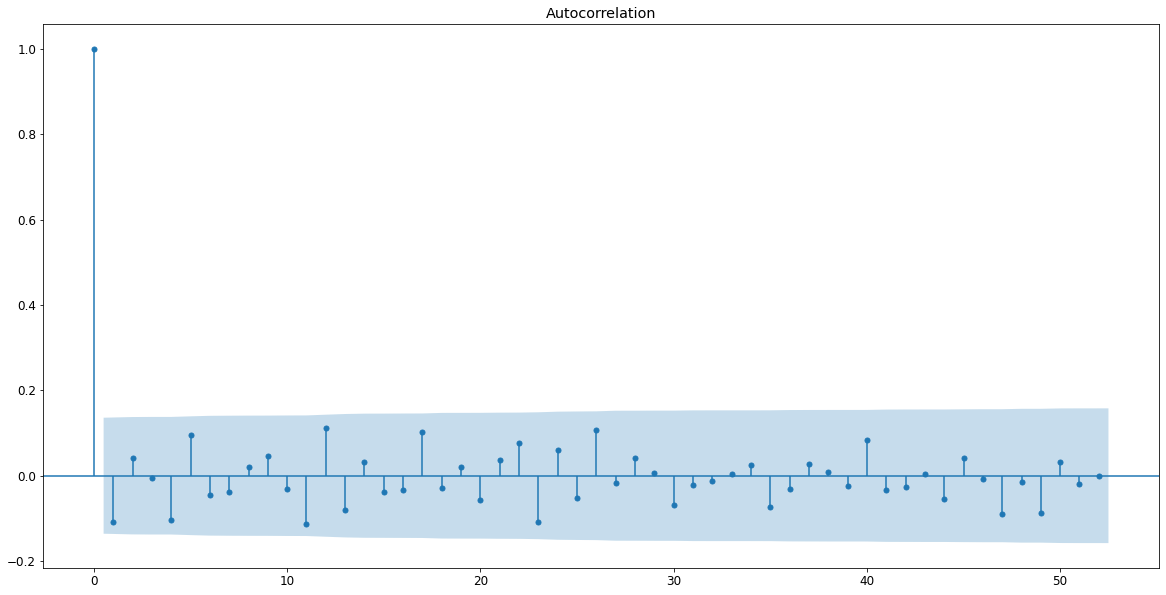

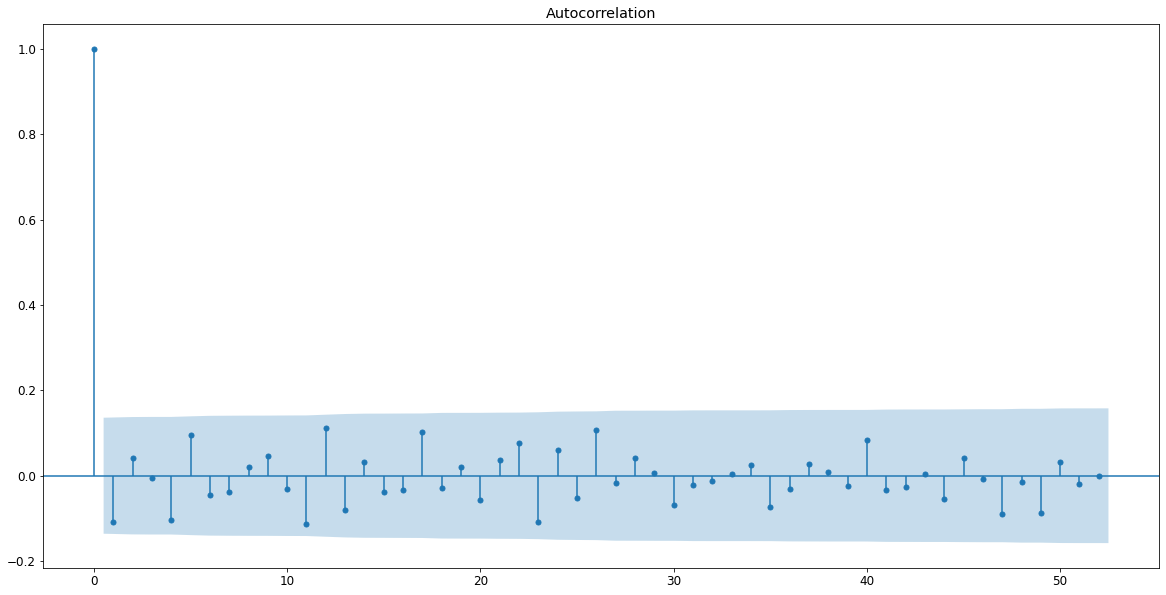

In [47]:
plot_acf(before_2014_diff, lags = 52)

# Partial Auto-Correlation

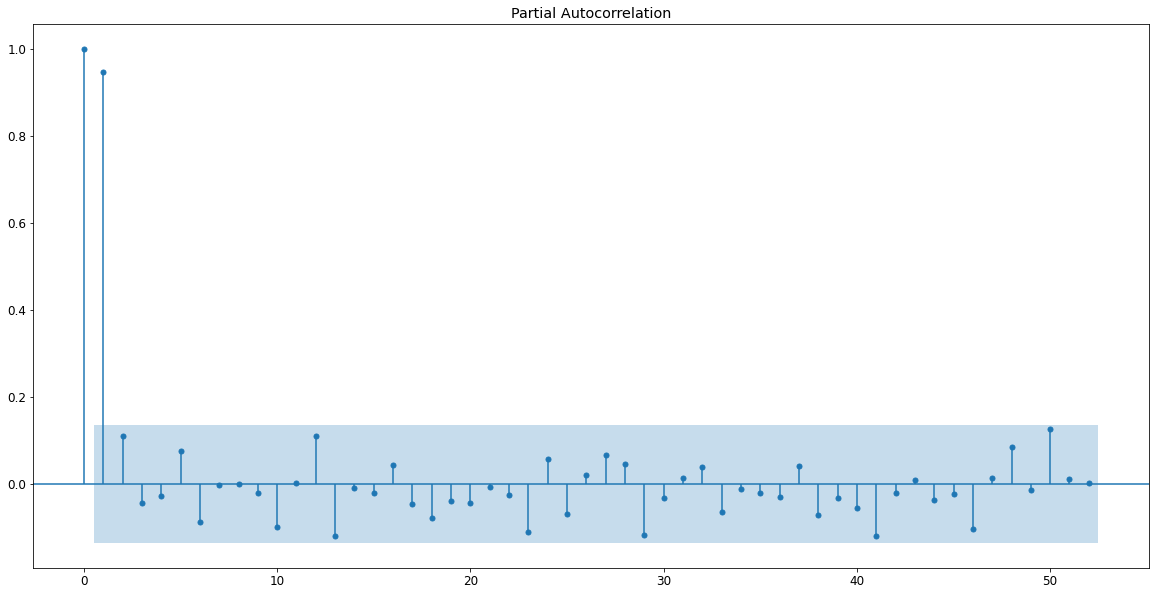

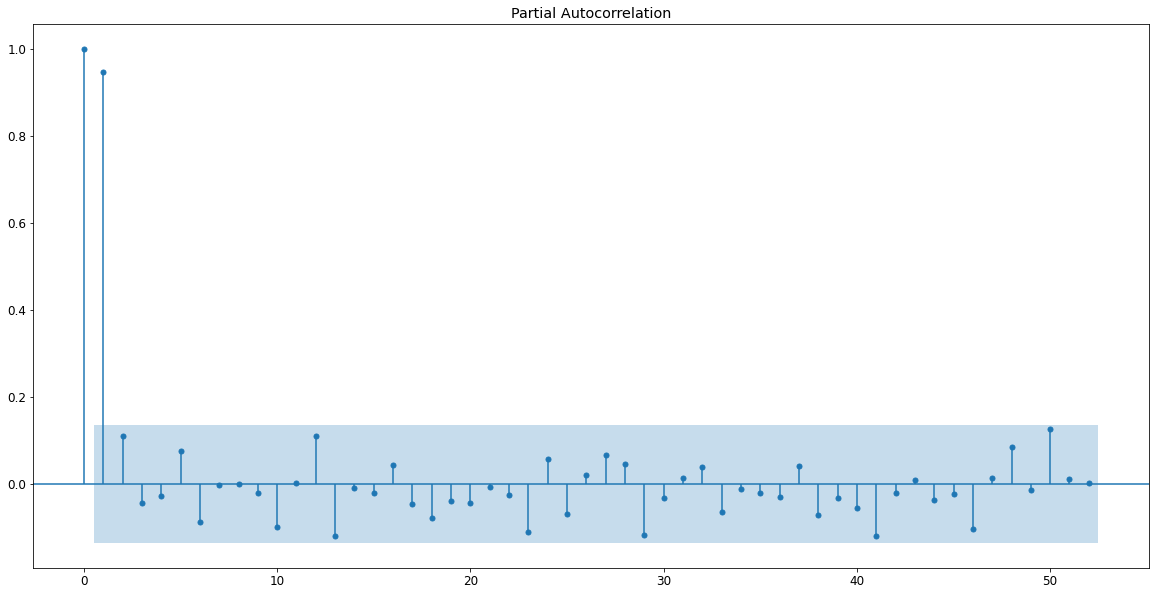

In [49]:
plot_pacf(before_2014, lags = 52)

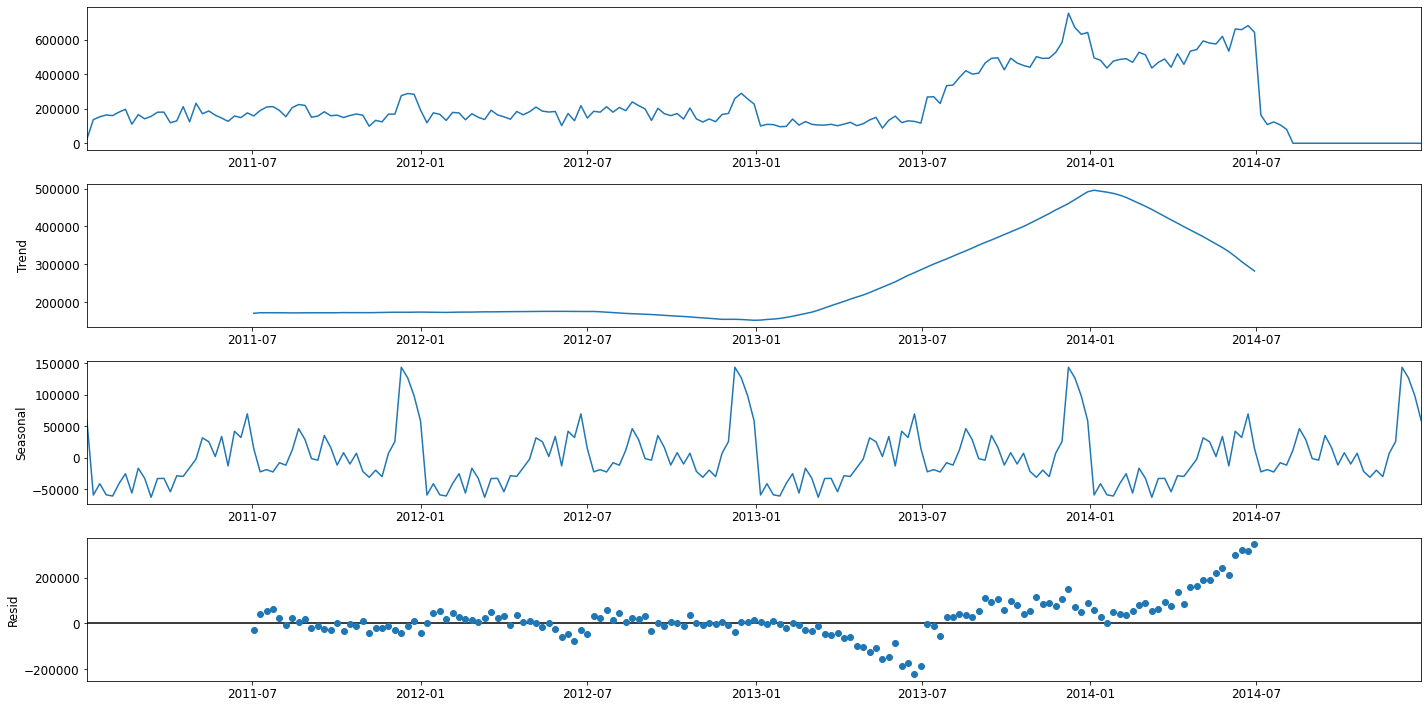

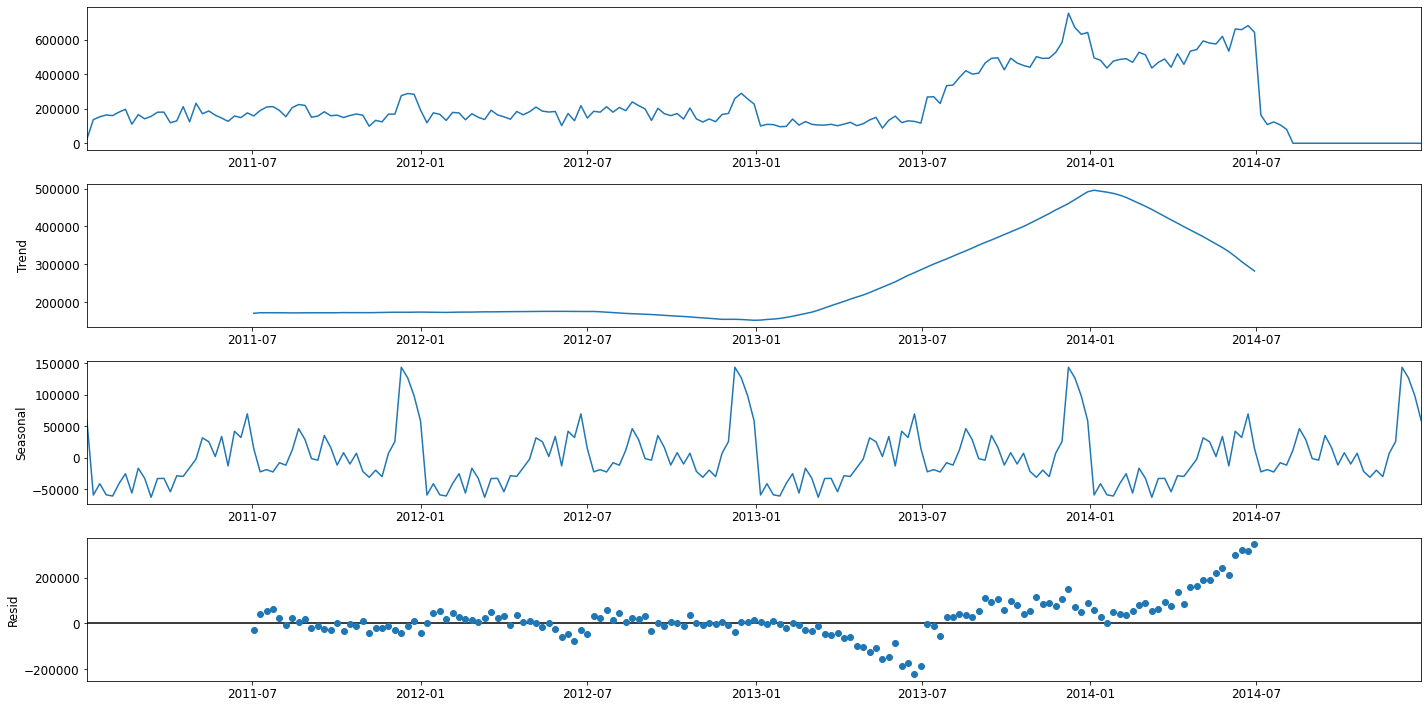

In [51]:
decomposition_diff = seasonal_decompose(before_2014_diff, period=52)
decomposition.plot()

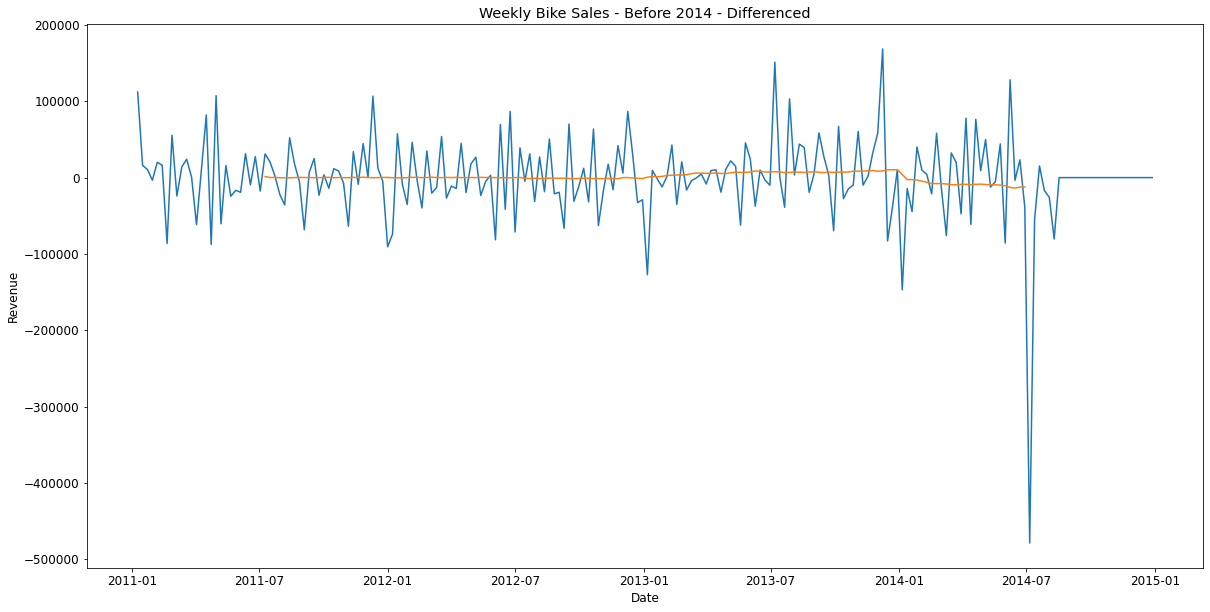

In [53]:
plt.title('Weekly Bike Sales - Before 2014 - Differenced')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.plot(before_2014_diff)
plt.plot(decomposition_diff.trend)

# Split the Data

In [100]:
train = before_2014_diff['2011':'2013'].dropna()
test = before_2014_diff['2014'].dropna()

#convert to 32-bit bc of memory
#train = train.astype(np.uint8,errors='ignore')

In [101]:
model_auto_arima = auto_arima(train, start_p = 1, start_q=1,
                                           max_p= 2, max_q=2, d=1, 
                                           seasonal=False, 
                                           trace=True, 
                                           error_action='ignore', 
                                           suppress_warnings=True, 
                                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3766.435, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3909.635, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3833.827, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3907.652, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3773.436, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3771.756, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3763.273, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3761.781, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3773.766, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3762.577, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3764.985, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 0.682 seconds


# ARIMA

In [102]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [103]:
#order= (p,d,q)

model_arima = ARIMA(train, order=(0,1,2),
                   enforce_stationarity = False,
                   enforce_invertibility=False)

In [104]:
results_arima = model_arima.fit()

In [123]:
#make predictions on the testing set

pred_arima = results_arima.predict(start='2014-01', end='2014-12-31')

In [124]:
pred_arima

2014-01-05    19498.693334
2014-01-12    11976.035461
2014-01-19    11976.035461
2014-01-26    11976.035461
2014-02-02    11976.035461
2014-02-09    11976.035461
2014-02-16    11976.035461
2014-02-23    11976.035461
2014-03-02    11976.035461
2014-03-09    11976.035461
2014-03-16    11976.035461
2014-03-23    11976.035461
2014-03-30    11976.035461
2014-04-06    11976.035461
2014-04-13    11976.035461
2014-04-20    11976.035461
2014-04-27    11976.035461
2014-05-04    11976.035461
2014-05-11    11976.035461
2014-05-18    11976.035461
2014-05-25    11976.035461
2014-06-01    11976.035461
2014-06-08    11976.035461
2014-06-15    11976.035461
2014-06-22    11976.035461
2014-06-29    11976.035461
2014-07-06    11976.035461
2014-07-13    11976.035461
2014-07-20    11976.035461
2014-07-27    11976.035461
2014-08-03    11976.035461
2014-08-10    11976.035461
2014-08-17    11976.035461
2014-08-24    11976.035461
2014-08-31    11976.035461
2014-09-07    11976.035461
2014-09-14    11976.035461
2

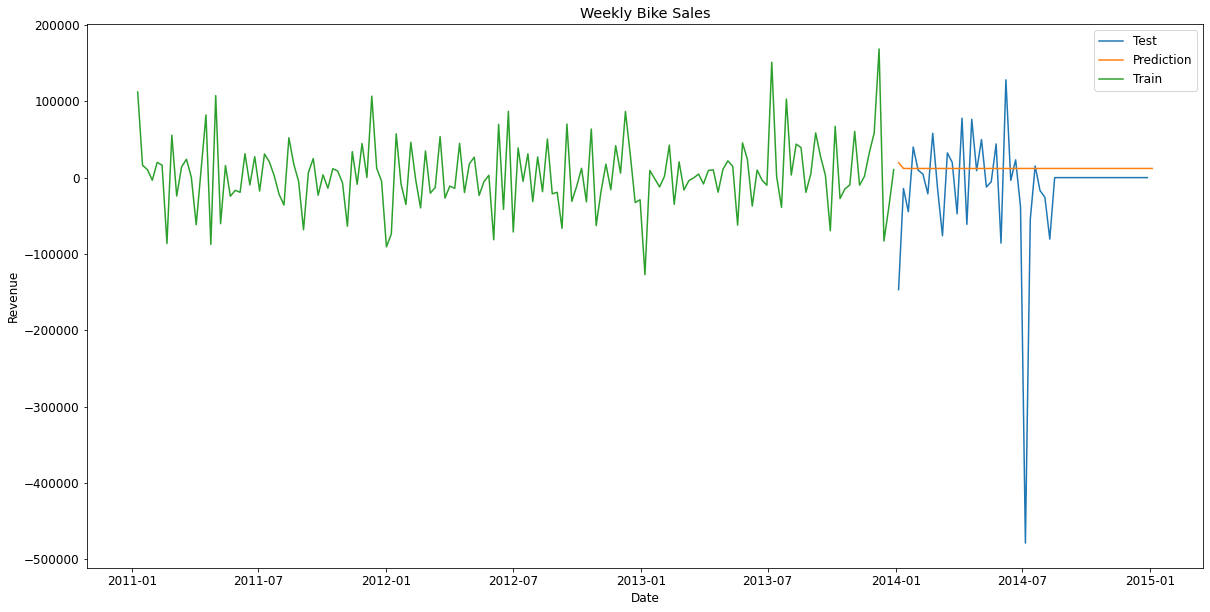

In [125]:
plt.plot(test, label="Test")
plt.plot(pred_arima, label="Prediction")
plt.plot(train, label ="Train")
plt.legend(loc="best")
plt.title('Weekly Bike Sales')
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

In [126]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [127]:
rmse = np.sqrt(mean_squared_error(test, pred_arima))

print("The RMSE is", rmse)

ValueError: Found input variables with inconsistent numbers of samples: [52, 53]